In [1]:
#necessary modules
from matplotlib import pyplot as plt
from pandas import DataFrame as DF
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller,grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.stats.stattools import durbin_watson
import statsmodels.tsa.api as smt
from statsmodels.tsa.api import VAR
register_matplotlib_converters()

%matplotlib inline

#Granger Causality function-çalışıyor
#The row are the response (y) and the columns are the predictor series (x).
def grangerCausality(data,variables,test='ssr_chi2test',verbose=False,lag=10):
    x_train=DF(np.zeros((len(variables),len(variables))),
               columns=variables,index=variables)
    for c in x_train.columns:
        for r in x_train.index:
            test_result=grangercausalitytests(data[[r,c]],maxlag=lag,verbose=False)
            p_values=[round(test_result[i+1][0][test][1],4) for i in range (lag)]
            if verbose:
                print(f'Y={r},X={c},P-values={p_values}')
            min_p_values=np.min(p_values)
            x_train.loc[r,c]=min_p_values
    x_train.columns=[var+'_x' for var in variables]
    x_train.index=[var+'_y' for var in variables]
    return x_train          
    

#Cointegration:Johansen Test-Çalışıyor
def cointegrationTest(data,alpha=0.05):
    out=coint_johansen(data,-1,5)
    d={'0.90': 0 , '0.95' :1, '0.99' :2}
    traces=out.lr1
    cvts=out.cvt[:,d[str(1-alpha)]]
    def adjust(val,length=6): return str(val).ljust(length)
    print('Name :: Test Stat > C(95%) => Signif \n','--'*20)
    for col,trace,cvt in zip(data.columns,traces,cvts):
        print(adjust(col),'::',adjust(round(trace,2),9),">",
             adjust(cvt,8),"=>", trace>cvt)
    return out.eig

#Variational Model-Çalışıyor
def varModel(data,maxLag=15):
    mod=smt.VAR(data)
    res=mod.fit(maxlags=maxLag,ic='aic')
    print(res.summary())

#ADFuller Test
def adfuller_test(data,signif=0.05,name='',verbose=False):
    r=adfuller(data,autolag='AIC')
    output={'test_statistics': round(r[0],4),'pvalue':round(r[1],4),'n_lags':round(r[2],4),
           'n_obs':r[3]}
    p_value=output['pvalue']
    def adjust(val,length=6): return str(val).ljust(length)
    #Print Summary
    print(f'Augmented Dickey-Fuller Test on "{name}"',"\n",'-'*47)
    print(f'Null Hypothesis:Data has unit root.Non-stationary.')
    print(f'Significance Level ={signif}')
    print(f'Test statistics    ={output["test_statistics"]}')
    print(f'No. Lags chosen    ={output["n_lags"]}')
          
    for key,val in r[4].items():
        print(f'Critical value{adjust(key,6)}={round(val,3)}')
    
    if p_value<=signif:
        print(f'=> P-Value={p_value}.Rejecting Null Hypothesis.')
        print(f'=> Series is Stationary.')
    else:
        print(f'=> P-Value={p_value}.Weak evidence to reject the Null Hypothesis')

def adfForAll(data):
    for name, column in data.iteritems():
        adfuller_test(column,name=column.name)
        print('\n')

#Durbin-Watson Statistic-Çalısıyor
def DW(data,lags=15):
    mod=smt.VAR(data)
    res=mod.fit(maxlags=lags,ic='aic')
    out=durbin_watson(res.resid)
    for col,val in zip(data.columns,out):
        print((col),':',round(val,2))

In [2]:
#load data from excel

In [3]:
original_data=pd.read_excel("exampleset.xls",index_col='Time')
original_data.columns

Index(['SeriesA', 'SeriesB', 'SeriesC', 'SeriesD', 'SeriesE', 'SeriesF',
       'SeriesG', 'Training '],
      dtype='object')

In [4]:
#split data into test and train 
train_data=original_data[original_data['Training ']==True]
test_data=original_data[original_data['Training ']==False]
test_data.head()

,SeriesA,SeriesB,SeriesC,SeriesD,SeriesE,SeriesF,SeriesG,Training
Time,,,,,,,,
11:26:00,74.072,82.844,112.650,120.025,142.566,71.116,109.920,False
11:28:00,74.142,82.869,112.682,120.077,142.631,71.191,109.939,False
11:30:00,74.136,82.867,112.669,120.067,142.565,71.164,109.938,False
11:32:00,74.163,82.889,112.700,120.107,142.593,71.195,109.966,False
11:34:00,74.259,82.962,112.792,120.234,142.700,71.299,110.057,False


In [7]:
#we can drop last column from our data which has label Training
test_data=test_data.drop(['Training '],axis=1)
train_data=train_data.drop(['Training '],axis=1)
train_data.tail()

,SeriesA,SeriesB,SeriesC,SeriesD,SeriesE,SeriesF,SeriesG
Time,,,,,,,
11:16:00,73.992,82.809,112.631,119.985,142.525,71.047,109.896
11:18:00,74.011,82.810,112.647,119.992,142.531,71.069,109.909
11:20:00,74.017,82.813,112.637,119.988,142.555,71.095,109.912
11:22:00,74.026,82.813,112.642,119.987,142.551,71.098,109.908
11:24:00,74.055,82.828,112.641,120.017,142.556,71.108,109.911


In [8]:
x = train_data.values
x_centered =DF(x - np.mean(x, axis=0),index=train_data.index, columns=train_data.columns)
x_centered.head()

,SeriesA,SeriesB,SeriesC,SeriesD,SeriesE,SeriesF,SeriesG
Time,,,,,,,
04:30:00,-0.060909,-0.052822,0.000279,0.005274,-0.075394,-0.075947,-0.018024
04:32:00,-0.062909,-0.055822,-0.000721,0.009274,-0.063394,-0.067947,-0.019024
04:34:00,-0.044909,-0.042822,0.003279,0.019274,-0.045394,-0.013947,-0.018024
04:36:00,-0.044909,-0.044822,0.003279,0.018274,-0.040394,-0.023947,-0.023024
04:38:00,-0.020909,-0.038822,0.003279,0.025274,-0.017394,-0.004947,-0.023024


In [14]:
grangerCausality(x_centered,variables=x_centered.columns)

,SeriesA_x,SeriesB_x,SeriesC_x,SeriesD_x,SeriesE_x,SeriesF_x,SeriesG_x
SeriesA_y,1.0000,0.0278,0.1021,0.3113,0.0105,0.0559,0.3590
SeriesB_y,0.0000,1.0000,0.0188,0.0024,0.0160,0.0123,0.0039
SeriesC_y,0.1383,0.4404,1.0000,0.0000,0.0010,0.0310,0.3152
SeriesD_y,0.0008,0.0378,0.0135,1.0000,0.0000,0.0000,0.1235
SeriesE_y,0.5065,0.0653,0.0747,0.0120,1.0000,0.1048,0.1695
SeriesF_y,0.3631,0.0872,0.0702,0.2099,0.1974,1.0000,0.0378
SeriesG_y,0.0276,0.4037,0.0301,0.1124,0.0062,0.0240,1.0000


In [9]:
coef=cointegrationTest(x_centered)
print(coef)

Name :: Test Stat > C(95%) => Signif 
 ----------------------------------------
SeriesA :: 117.57    > 111.7797 => True
SeriesB :: 73.87     > 83.9383  => False
SeriesC :: 45.67     > 60.0627  => False
SeriesD :: 31.82     > 40.1749  => False
SeriesE :: 19.37     > 24.2761  => False
SeriesF :: 10.28     > 12.3212  => False
SeriesG :: 4.54      > 4.1296   => True
[0.19453261 0.13031631 0.0662509  0.05976813 0.04403223 0.02798475
 0.02224622]


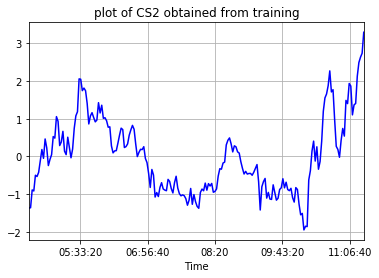

In [19]:
#cointegrated series cs1:
cs1=coef[0]*x_centered['SeriesA']+coef[1]*x_centered['SeriesB']+coef[2]*x_centered['SeriesC']+coef[3]*train_data['SeriesD']+coef[4]*x_centered['SeriesE']+coef[5]*x_centered['SeriesF']+coef[6]*x_centered['SeriesG']
cs1=DF(cs1,index=x_centered.index,columns=['cs1'])
cs2=(cs1-cs1.mean())/cs1.std()
axes=cs2.cs1.plot(color='blue',label='Actual SeriesA',grid=True,title="plot of CS2 obtained from training")

In [8]:
train_data.values[-15:]

array([[ 73.934,  82.773, 112.55 , 119.886, 142.485,  71.02 , 109.875],
       [ 73.94 ,  82.778, 112.576, 119.919, 142.492,  71.012, 109.878],
       [ 73.947,  82.773, 112.562, 119.901, 142.437,  71.02 , 109.873],
       [ 73.986,  82.79 , 112.583, 119.942, 142.477,  71.055, 109.892],
       [ 73.986,  82.791, 112.575, 119.919, 142.477,  71.062, 109.895],
       [ 74.007,  82.804, 112.58 , 119.945, 142.51 ,  71.076, 109.894],
       [ 73.998,  82.808, 112.577, 119.952, 142.507,  71.069, 109.899],
       [ 73.957,  82.782, 112.581, 119.943, 142.495,  71.034, 109.88 ],
       [ 73.962,  82.788, 112.617, 119.945, 142.507,  71.026, 109.886],
       [ 73.968,  82.785, 112.613, 119.954, 142.504,  71.021, 109.882],
       [ 73.992,  82.809, 112.631, 119.985, 142.525,  71.047, 109.896],
       [ 74.011,  82.81 , 112.647, 119.992, 142.531,  71.069, 109.909],
       [ 74.017,  82.813, 112.637, 119.988, 142.555,  71.095, 109.912],
       [ 74.026,  82.813, 112.642, 119.987, 142.551,  71.098, 10

In [36]:
model = smt.VAR(train_data.diff().dropna())
res = model.fit(ic='aic')
print(res.summary())
prediction=res.forecast(train_data.diff()[-50:].values[-100:],227)
pred_df=DF(prediction,index=test_data.index,columns=test_data.columns)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 08, Mar, 2020
Time:                     12:33:31
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                   -65.6835
Nobs:                     206.000    HQIC:                  -66.2222
Log likelihood:           4868.47    FPE:                1.20577e-29
AIC:                     -66.5881    Det(Omega_mle):     9.23504e-30
--------------------------------------------------------------------
Results for equation SeriesA
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const              0.001009         0.000960            1.052           0.293
L1.SeriesA         0.128416         0.134442            0.955           0.339
L1.SeriesB        -0.415869         0.178664           -2.328         

C:\Users\pc\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [12]:
#Durbin-Watson stats
DW(x_centered.dropna())

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


SeriesA : 2.03
SeriesB : 2.11
SeriesC : 2.07
SeriesD : 2.0
SeriesE : 2.03
SeriesF : 1.97
SeriesG : 2.07


In [15]:
#Dicky Fuller Test results
adfForAll(x_centered)

Augmented Dickey-Fuller Test on "SeriesA" 
 -----------------------------------------------
Null Hypothesis:Data has unit root.Non-stationary.
Significance Level =0.05
Test statistics    =-1.2835
No. Lags chosen    =12
Critical value1%    =-3.464
Critical value5%    =-2.876
Critical value10%   =-2.575
=> P-Value=0.6367.Weak evidence to reject the Null Hypothesis


Augmented Dickey-Fuller Test on "SeriesB" 
 -----------------------------------------------
Null Hypothesis:Data has unit root.Non-stationary.
Significance Level =0.05
Test statistics    =-1.0574
No. Lags chosen    =0
Critical value1%    =-3.462
Critical value5%    =-2.876
Critical value10%   =-2.574
=> P-Value=0.7318.Weak evidence to reject the Null Hypothesis


Augmented Dickey-Fuller Test on "SeriesC" 
 -----------------------------------------------
Null Hypothesis:Data has unit root.Non-stationary.
Significance Level =0.05
Test statistics    =-1.9374
No. Lags chosen    =1
Critical value1%    =-3.462
Critical value5%    =

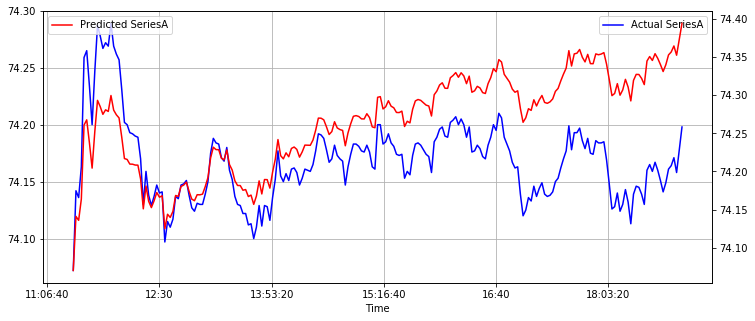

In [12]:
pred_inverse=pred_df.cumsum()
pred_df=pred_inverse+test_data
plt.figure(figsize=(12,5))
plt.xlabel('DateTime')

ax1=test_data.SeriesA.plot(color='blue',label='Actual SeriesA',grid=True)

ax2=pred_df.SeriesA.plot(color='red',label='Predicted SeriesA',grid=True,secondary_y=True)
ax1.legend(loc=1)
ax2.legend(loc=2)

plt.show()